Train the model

Match Functionality and Result

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.1444 - loss: 16.6394 - val_accuracy: 0.1562 - val_loss: 12.5643
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4375 - loss: 5.6042 - val_accuracy: 0.4615 - val_loss: 5.6181
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 670ms/step - accuracy: 0.2676 - loss: 8.4986 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.3125 - loss: 4.7830 - val_accuracy: 0.5000 - val_loss: 4.4512
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 807ms/step - accuracy: 0.5106 - loss: 4.2447 - val_accuracy: 0.6923 - val_loss: 4.6013
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5789 - loss: 2.2404 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 907ms/step - accuracy: 0.5778 - loss: 4.0694 - val_accuracy: 0.6562 - val_loss: 3.1447
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.8421 - loss: 0.2360 - val_accuracy: 0.7692

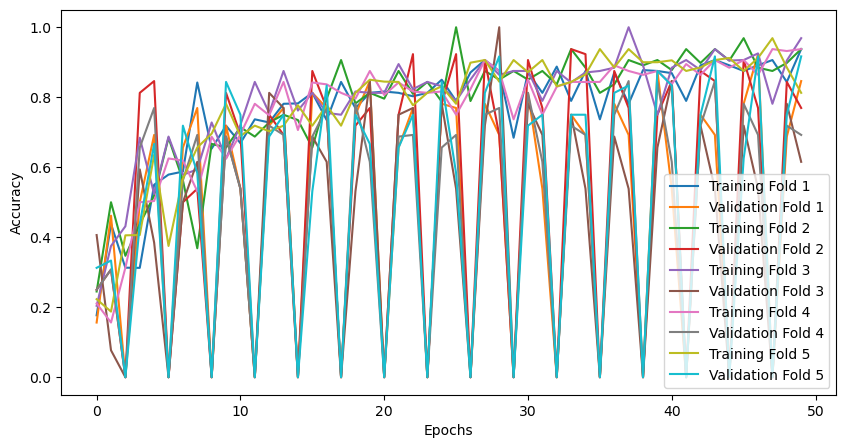

In [22]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Step 1: Data Collection and Preparation
def load_images_from_folders(root_folder, target_size=(100, 100)):
    images = []
    labels = []
    folders = sorted(os.listdir(root_folder))
    
    for folder_name in folders:
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):
            filenames = sorted(os.listdir(folder_path))
            for filename in filenames:
                img = cv2.imread(os.path.join(folder_path, filename))
                if img is not None:
                    img = cv2.resize(img, target_size)
                    images.append(img)
                    labels.append(folder_name)
                    
    return np.array(images), np.array(labels)

# Load images from folders and automatically label them
images, labels = load_images_from_folders("new")

# Encode labels as integers
label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
encoded_labels = np.array([label_mapping[label] for label in labels])

# Shuffle the data
indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]
encoded_labels = encoded_labels[indices]

# Data augmentation with adjusted settings
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Step 2: Model Training
def create_model(input_shape, num_classes):
    model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape)
    
    for layer in model.layers:
        layer.trainable = False
    
    x = model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs=model.input, outputs=x)

def train_model(images, labels):
    kfold = KFold(n_splits=5, shuffle=True)
    val_accuracies = []
    histories = []

    for train_indices, val_indices in kfold.split(images):
        train_images, val_images = images[train_indices], images[val_indices]
        train_labels, val_labels = labels[train_indices], labels[val_indices]

        train_generator = datagen.flow(train_images, train_labels, batch_size=32)
        val_generator = datagen.flow(val_images, val_labels, batch_size=32)

        model = create_model(input_shape=train_images[0].shape, num_classes=len(label_mapping))
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(train_generator,
                            steps_per_epoch=len(train_images) // 32,
                            epochs=50,
                            validation_data=val_generator,
                            validation_steps=len(val_images) // 32)
        histories.append(history)
        val_accuracies.append(history.history['val_accuracy'][-1])

    print("Average Validation Accuracy:", np.mean(val_accuracies))

    return model, histories

# Train the model
model, histories = train_model(images, encoded_labels)

# Save the model in the native Keras format
model.save("face_recognition_model_updated.keras")

# Evaluate the model on the training data
loss, accuracy = model.evaluate(images, encoded_labels)
print("Training Loss:", loss)
print("Training Accuracy:", accuracy)

# Plot training history
plt.figure(figsize=(10, 5))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Training Fold {i+1}')
    plt.plot(history.history['val_accuracy'], label=f'Validation Fold {i+1}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [29]:
def preprocess_image(image):
    """Preprocesses an image for use in the model."""
    try:
        # Crop to square aspect ratio (1:1) from the center
        height, width = image.shape[:2]
        if height > width:
            y = (height - width) // 2
            cropped_image = image[y:y+width, :]
        else:
            x = (width - height) // 2
            cropped_image = image[:, x:x+height]

        # Convert cropped image to grayscale
        gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

        # Face detection
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100))
        if len(faces) == 0:
            print("Error: No face detected.")
            return None

        # Get coordinates of the first detected face
        (x, y, w, h) = faces[0]

        # Crop and resize the face region
        face_image = cropped_image[y:y+h, x:x+w]
        resized_image = cv2.resize(face_image, (100, 100))

        # Normalize image
        resized_image = resized_image / 255.0

        return resized_image
    except Exception as e:
        print("Error:", e)
        return None

def match_person(image):
    processed_image = preprocess_image(image)
    if processed_image is None:  
        return "Failed to capture or process image"
    predictions = model.predict(np.expand_dims(processed_image, axis=0))
    person_index = np.argmax(predictions)
    if person_index in label_mapping.values():
        person_name = [name for name, idx in label_mapping.items() if idx == person_index][0]
        return person_name
    else:
        return "Unknown"


type 'start' to start:  start


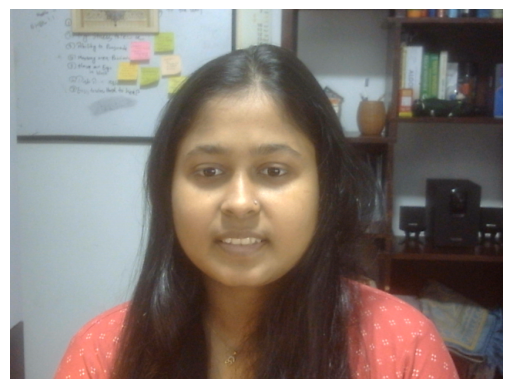

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Matching Result: MST ROKEYA KHATUN


In [31]:
def capture_image():
    # Initialize the camera
    cap = cv2.VideoCapture(0)

    # Check if the camera is opened successfully
    if not cap.isOpened():
        print("Error: Could not open camera")
        return

    # Read and display the camera feed
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Failed to capture frame")
            break

        # Display the frame in a window
        cv2.imshow('Camera', frame)

        # Check for key press
        key = cv2.waitKey(1)
        if key == ord('q'):  # Press 'q' to exit
            break
        elif key == ord('c'):  # Press 'c' to capture
            cv2.imwrite('captured_image.jpg', frame)
            cv2.imshow('Captured Image', frame)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    # Release the camera and close all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()

takeInput = input("type 'start' to start: ")

if takeInput == "start":
    capture_image()
    # image_path = "new/MD NAIMUR RAHMAN/photo.jpg"
    image_path = "captured_image.jpg"
    image = cv2.imread(image_path)
    result = match_person(image)
    print("Matching Result:", result)
    
else:
    print("Your input is wrong!")